In [2]:
%matplotlib inline
import numpy as np
import scipy
import numpy.testing as npt
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [3]:
class PCA():

    """ 
    PCA class to calculate principle components of dataset X
    
    Parameters:
        Xtrain: (n * d) matrix
        C is the d-dimensional center of the data
        U is a d × d matrix, which contains the principal directions (one direction per column)
        D is a vector of length d, which contains the principal values sorted in descending order (i.e. D1 ≥
        D2 . . .). The principle values should represent the sample variance along the principle component
        directions.
        
    """
    
    def __init__(self, Xtrain: np.ndarray):
        self.Xtrain = Xtrain

        # Shape of dataset
        self.n, self.d = Xtrain.shape
        # Computing the center of data
        self.C = np.mean(Xtrain, axis=0)

        # Centered data
        self.X_train_centered = Xtrain - self.C

        # Computing cov matrix
        self.cov = np.cov(self.X_train_centered, rowvar=False)
            
        # Computing eigenvalues und eigenvectors
        eigval, eigvec = np.linalg.eigh(self.cov)
        
        # sorting eigval and eigvec
        sorted_ind = np.argsort(eigval)[::-1]
        eigval = eigval[sorted_ind]
        eigvec = eigvec[:,sorted_ind]
        
        self.U = eigvec
        self.D = eigval

    def project(self, Xtest, m):
        # self.C = np.mean(Xtest, axis=1)[:, None]
        # Center of data
        X_test_centered = Xtest - self.C 
        # Project the centered data onto the m principal directions
        Z = X_test_centered @ self.U[:,:m]
        return Z
        
    def denoise(self, Xtest, m):
        # Projecting the test data onto the first m PC
        Z = self.project(Xtest,m)
        # Reconstructing the denoised data
        Y = self.C + Z @ self.U[:,:m].T
        return Y

Assignment 2 (5 pts)

In [4]:
def gammaidx(X, k):
    """
    Calculate gamma index for each data point

    Parameters:
        X: (n * d)  matrix containing the data points
        k: number of neighbours --> scalar
    Return:
        y_index for each data points: (1 * n)  1D array 
    """
    # Calculating distances
    dist = np.sqrt(np.sum((X[:, None, :] - X)**2, axis=-1))
    #dist = np.sqrt(np.sum((X[:,np.newaxis]-X[np.newaxis,:])**2,axis=-1))
    print(f"Distances:\n{dist.shape}")
    
    # Sort the distances for each point and select the K nearest neighbors
    nearest_ind = np.argsort(dist, axis=1)[:, :k+1]
    print(f"nearest_indices:\n{nearest_ind}")

    # Calculate the sum of squared distances to the K nearest neighbors for each point
    sum_dist = np.sum(dist[np.arange(len(X))[:, None], nearest_ind], axis=-1)
    print(f"Sum_distances:\n{sum_dist}")

    y = sum_dist / k
    
    return y

Assignment 3 (10 pts)

In [5]:
def auc(y_true, y_pred, plot=False):
    # Sort the predicted values along with their corresponding true labels
    sorted_indices = np.argsort(y_pred)
    y_true_sorted = y_true[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]
    
    # Count the number of positive and negative instances
    n_pos = np.sum(y_true_sorted == 1)
    n_neg = np.sum(y_true_sorted == -1)
    
    # Compute True Positive Rate (TPR) and False Positive Rate (FPR)
    cum_tp = np.cumsum(y_true_sorted == 1)
    cum_fp = np.cumsum(y_true_sorted == -1)
    
    tpr = cum_tp / n_pos
    fpr = cum_fp / n_neg
    
    # Compute the area under the ROC curve (AUC)
    c = 1-np.trapz(tpr, fpr)
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.show()
    
    return c


In [6]:
def lle(X, m, tol, n_rule, k=None, epsilon=None):

    
    # Check if parameters are valid
    if n_rule not in ['knn', 'eps-ball']:
        raise ValueError("Invalid neighborhood rule. Please choose 'knn' or 'eps-ball'.")
    if k is None and epsilon is None:
        raise ValueError("Either k or epsilon must be provided.")
    if n_rule == 'knn' and (k is None or k <= 0):
        raise ValueError("Invalid value for k. k must be a positive integer.")
    if tol <= 0:
        raise ValueError("Regularization parameter 'tol' must be positive.")

    n, d = X.shape

    # Compute distance
    dist = np.sqrt(np.sum((X[:,np.newaxis]-X[np.newaxis,:])**2,axis=-1))

    # we don't want to have the data point in the list of nearest neighbours
    np.fill_diagonal(dist,np.inf)

    # Construct neighborhood graph based on n_rule
    if n_rule == "knn":
        if k>=n:
            raise ValueError("The number of neighbors k must be less than the number of data points n.")
        else:    
            ind = np.argsort(dist, axis=0)[:k,:]

    elif n_rule == "eps-ball":
        if epsilon is None:
            raise ValueError("Parameter 'epsilon' must be provided.")
        else:
            ind =[]
            for i in range(n):
                indice = np.where(dist[:,i] <= epsilon)[0]
                ind.append(indice)
            #neighbors = np.concatenate([X[i] for i in ind])
            #ind = np.concatenate(ind)
    else:
        raise ValueError("Please choose either knn or eps-ball for neighborhood rule")

    neighbors = X[ind]

    # Part 1: local reconstruction weights
    # Compute weights for reconstruction
    W = np.zeros([n,n], dtype=float)
    for i in range(n):
        x = X[i]
        diff = x - neighbors[i]
        
        # Covariance matrice
        C = (diff @ diff.T)
        C += (np.identity(len(ind[i])).reshape(len(ind[i]), -1)* tol * np.trace(C))
        
        # CW=1 with solve linear problem to find W
        w = np.linalg.solve(C, np.ones(len(ind[i])))
        # Normalized W
        w /= np.sum(w)
        W[i, ind[i]] = w


    # Part 2: compute embedding
    
    # M=(I-W)^T.(I-W)
    M = np.identity(N) - W - W.T + np.dot(W.T,W)
    Y = np.linalg.svd(M)[0][:,-2:-(m+2):-1]

    return Y

In [7]:
import os
import scipy.io
# Get the current directory
current_dir = os.getcwd()

# Navigate to the parent directory (one folder back)
parent_dir = os.path.dirname(current_dir)

# Construct the path to the "ups.mat" file
usps_path = os.path.join(parent_dir, 'data', 'usps.mat')

# Load the MATLAB file
usps_data = scipy.io.loadmat(r"data\usps.mat")

# we have to transpose dataset because dataset is d*n and our PCA class gets n*d dataset
images = usps_data['data_patterns'].T

labels = usps_data['data_labels']
total_class = labels.shape[0]
print(f"The shape of image {images.shape} and shape of label {labels.shape} that means the total class of digits are {labels.shape[0]} classes")

The shape of image (2007, 256) and shape of label (10, 2007) that means the total class of digits are 10 classes


2. (a) Calculate the PCA of this data.

In [8]:
# Calculation the PCA of this dataset
pca = PCA(images)
print(pca.U.shape)
print(pca.Xtrain.shape)

(256, 256)
(2007, 256)


In [9]:
def visualization(images, title = "Visualizing PCA"):
    class_indices = {}
    plt.suptitle(title)
    for i in range(total_class):
        idx = np.where(labels[i] == 1)[0]
        class_indices[i] = idx
        pca = PCA(images[idx,:])
        print(f"shape of data for calss {i} is {(pca.n,pca.d)}")
        plt.subplots_adjust(top=0.85)
        plt.subplot(1,2,1)
        plt.bar(np.arange(0,len(pca.D)), pca.D, align="center")
        plt.xlabel("Principal Component")
        plt.ylabel("Principal Value", loc="center", labelpad=5)
        plt.title(f"All Principal Values of class{i}")
        
        # Visualization of the largest 25 principal values as a bar plot
        plt.subplot(1,2,2)
        plt.bar(np.arange(0,25), pca.D[:25], align='center')
        plt.xlabel("Principal Component")
        plt.title (f"25 principal values of class{i}")
        plt.show()
        
        # Visualization of the first 5 principal directions as images
        plt.suptitle(f"Visualization of the first 5 principal directions\n of class{i}")
        plt.subplots_adjust(top=1.5)
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(pca.U[:, i].reshape(16,16))
            plt.axis('off')
        plt.show()

shape of data for calss 0 is (359, 256)


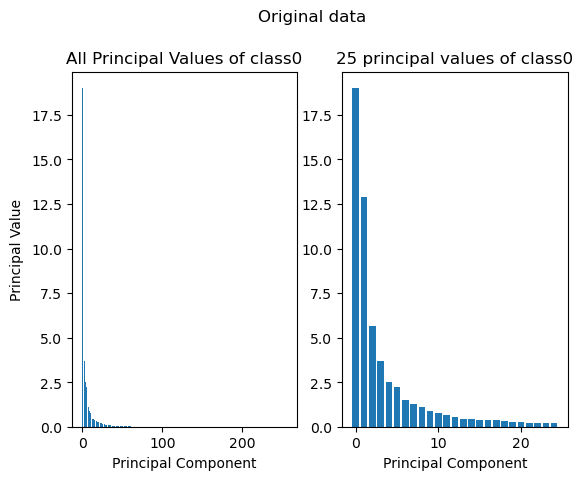

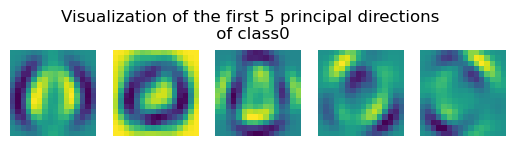

shape of data for calss 1 is (264, 256)


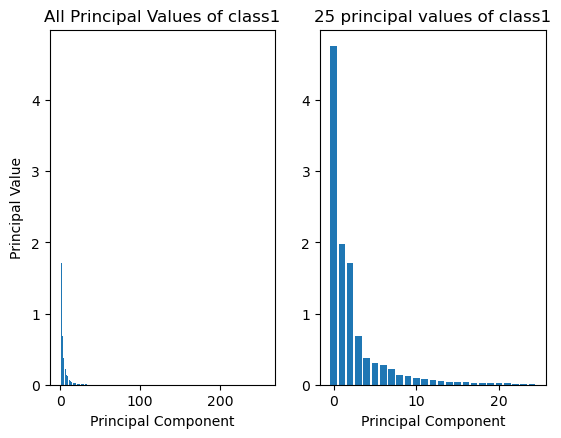

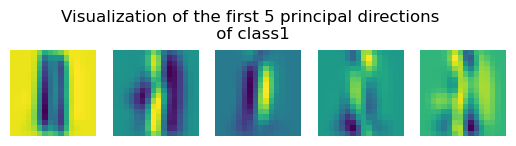

shape of data for calss 2 is (198, 256)


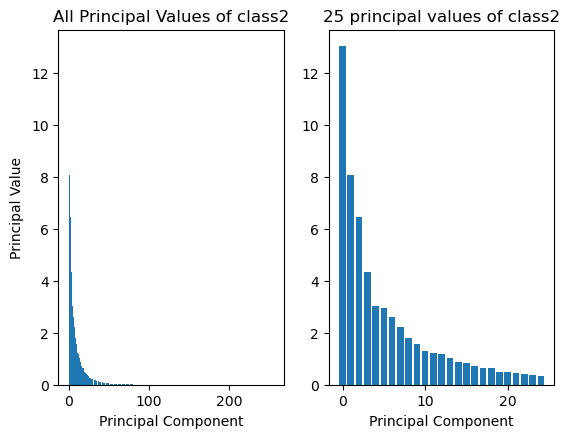

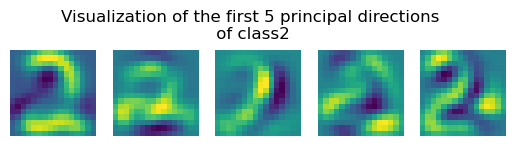

shape of data for calss 3 is (166, 256)


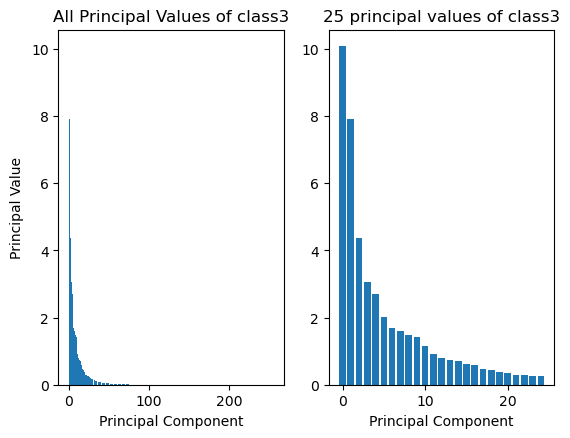

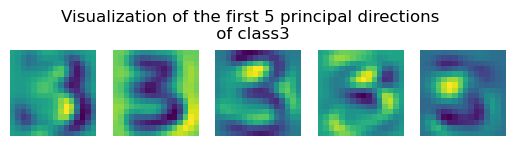

shape of data for calss 4 is (200, 256)


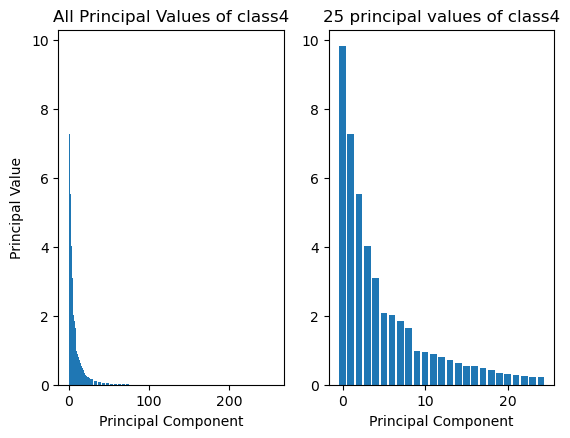

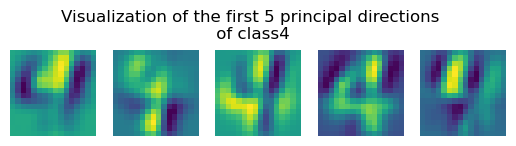

shape of data for calss 5 is (160, 256)


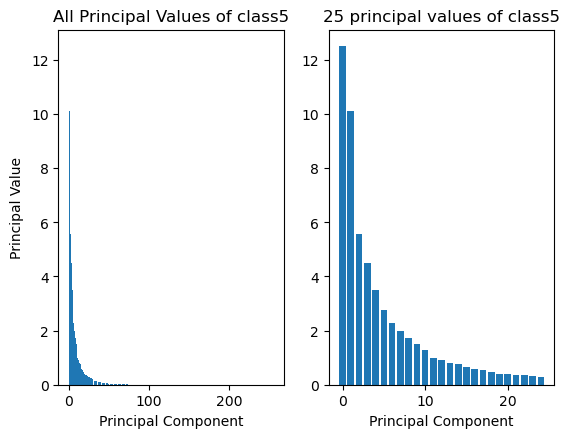

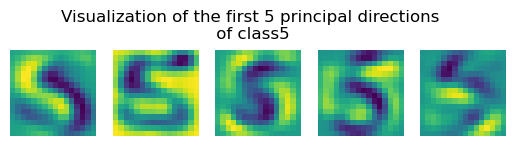

shape of data for calss 6 is (170, 256)


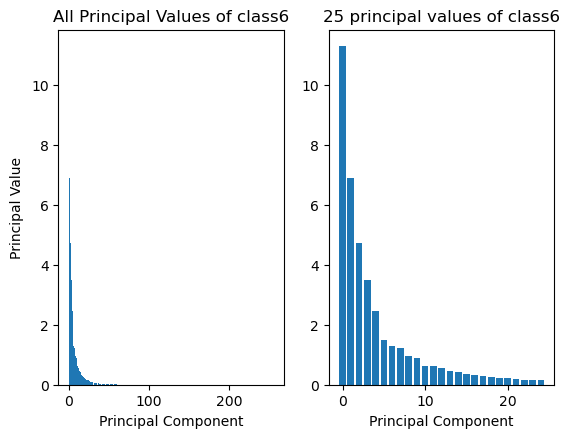

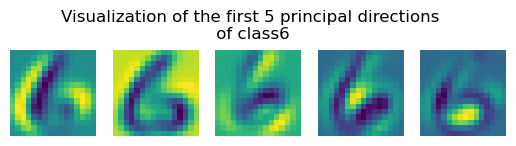

shape of data for calss 7 is (147, 256)


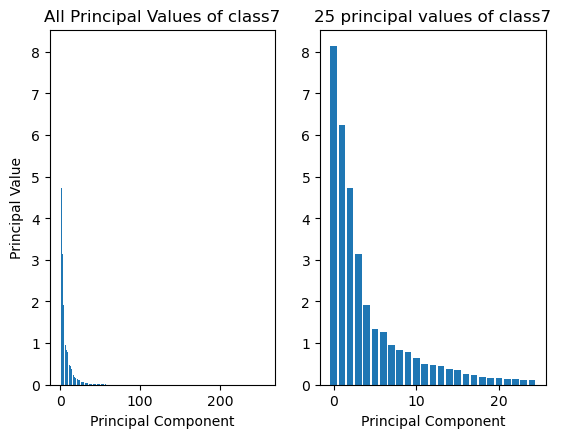

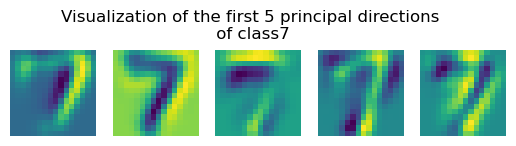

shape of data for calss 8 is (166, 256)


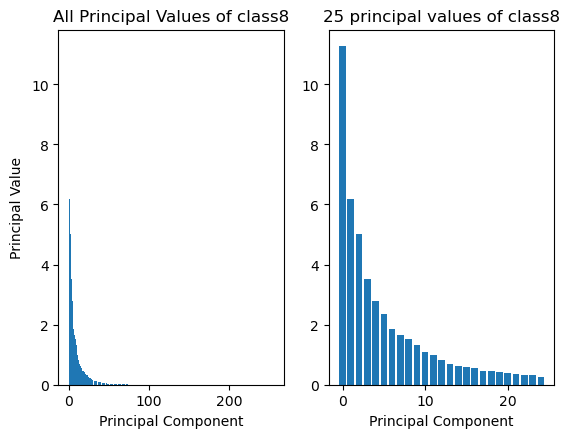

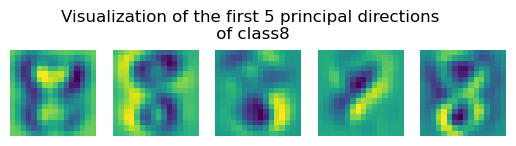

shape of data for calss 9 is (177, 256)


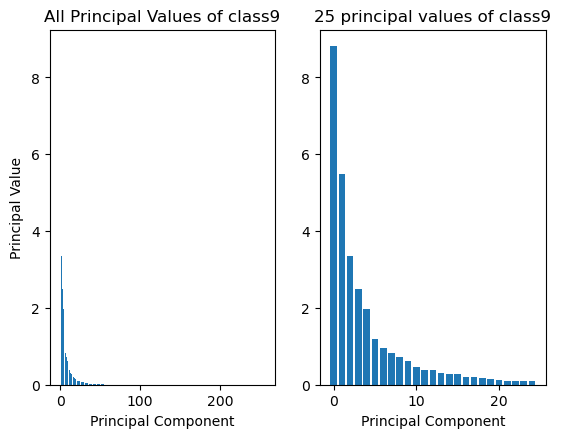

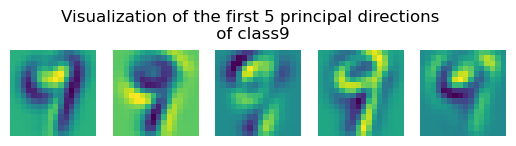

In [10]:
visualization(images, "Original data")

In [11]:
#Plot images
def image_viz(data, title):
    plt.figure(figsize=(3.5,5))
    plt.suptitle('Images with %s'%title)
    plt.subplots_adjust(top=1.67)
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(data[i, :].reshape(16,16))
        plt.axis('off')
    plt.show()


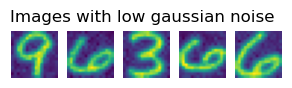

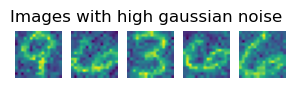

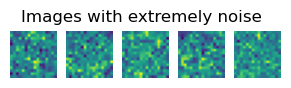

In [12]:
#3. Adding noise
np.random.seed(43)
noise=np.random.randn(images.shape[0], images.shape[1])

# Images with low gaussian noise
images_low_noise = 0.10 * noise + images
image_viz(images_low_noise, "low gaussian noise")

# Images with high gaussian noise
images_high_noise = 0.40 * noise + images
image_viz(images_high_noise, "high gaussian noise")

# 5 images with extremely noise. Images are beyond human recognition
images_extrem_noise = images + 1.8 * noise
image_viz(images_extrem_noise, "extremely noise")


shape of data for calss 0 is (359, 256)


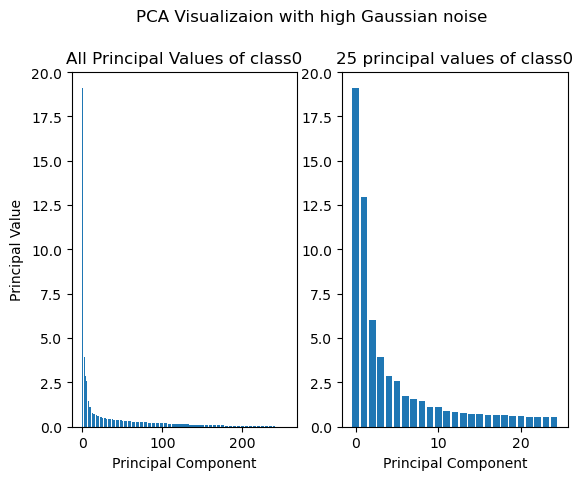

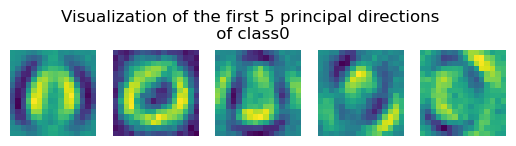

shape of data for calss 1 is (264, 256)


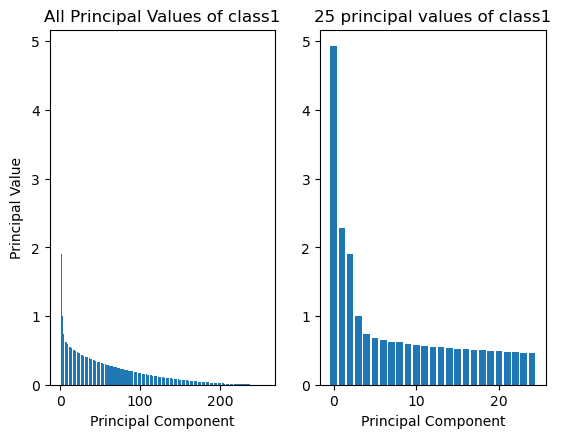

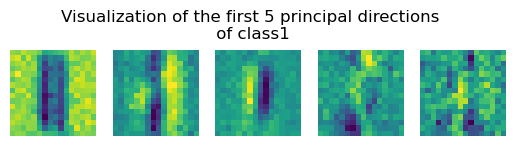

shape of data for calss 2 is (198, 256)


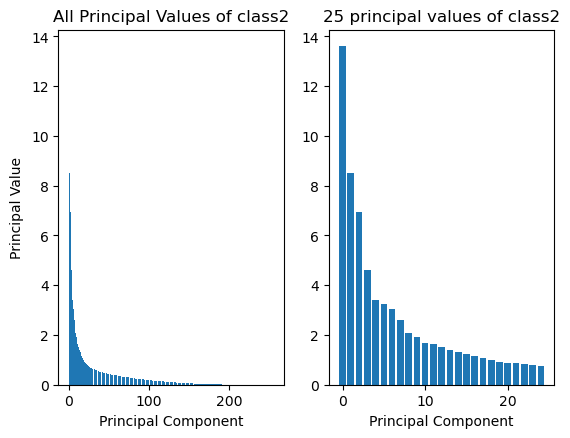

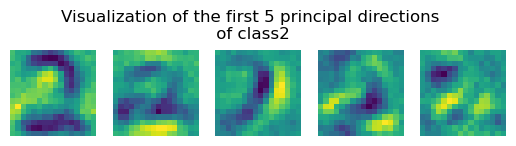

shape of data for calss 3 is (166, 256)


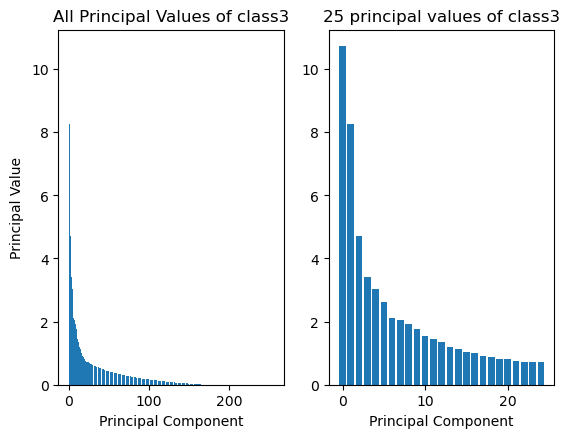

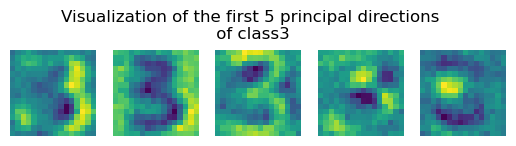

shape of data for calss 4 is (200, 256)


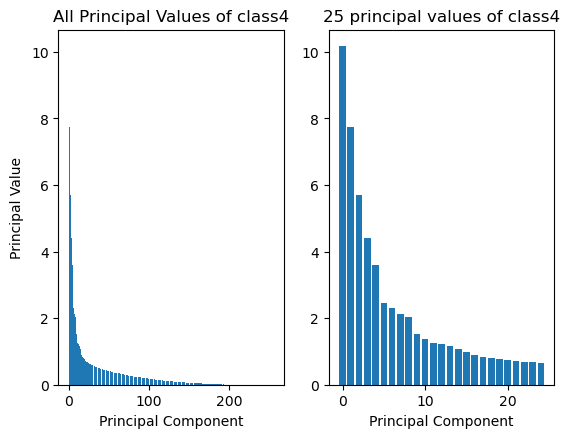

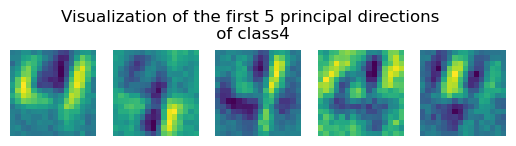

shape of data for calss 5 is (160, 256)


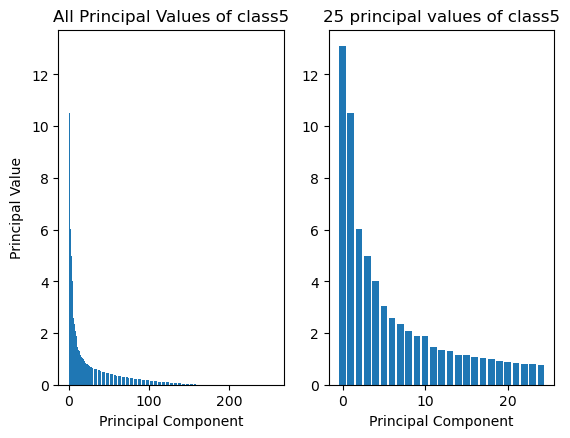

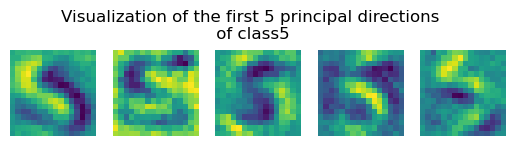

shape of data for calss 6 is (170, 256)


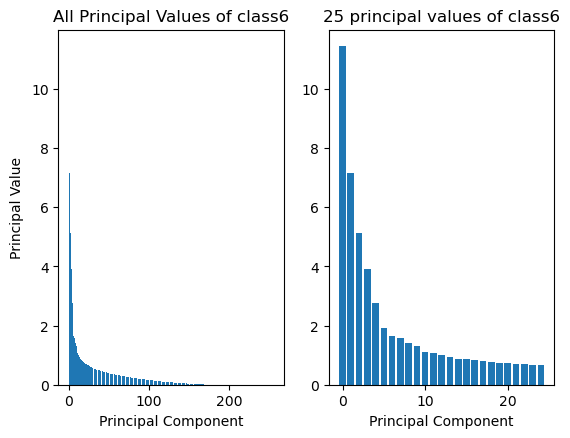

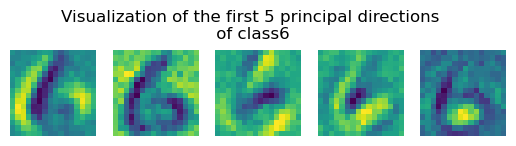

shape of data for calss 7 is (147, 256)


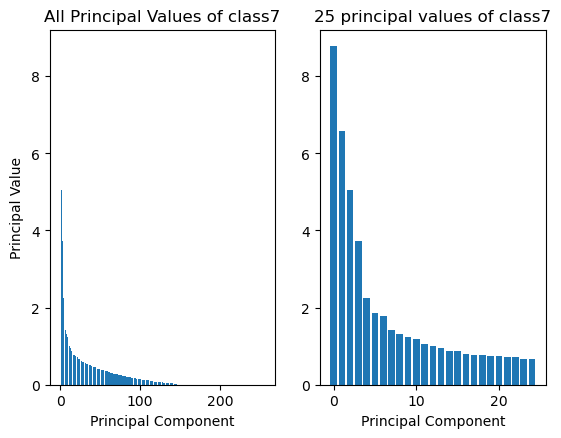

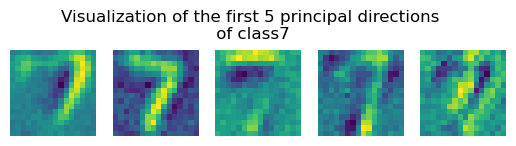

shape of data for calss 8 is (166, 256)


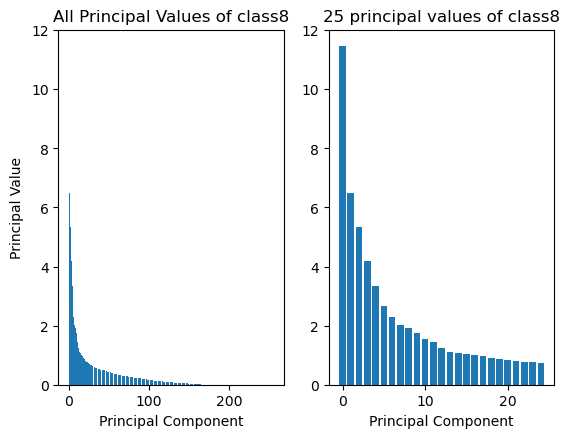

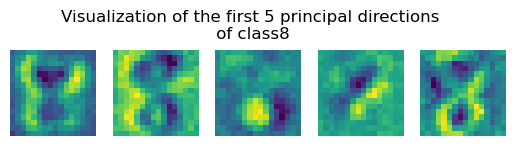

shape of data for calss 9 is (177, 256)


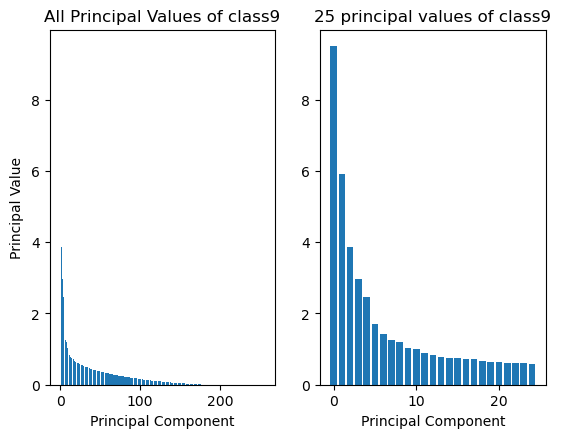

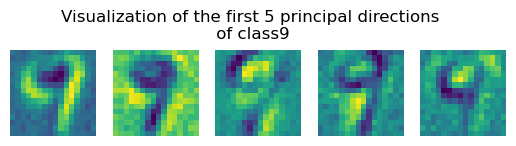

In [13]:
# Calculation of PCA (high noise)
visualization(images_high_noise, "PCA Visualizaion with high Gaussian noise")

In [14]:
def visualisation5_images(data, title): 
    #Visualization of all principal values as a bar plot
    plt.suptitle(title)
    plt.subplots_adjust(top=0.85)
    plt.subplot(1,2,1)
    plt.bar(np.arange(0,len(PCA(data).D)), PCA(data).D, align='center')
    plt.xlabel('Principal Component')
    plt.ylabel('Principal Value', loc='center', labelpad=5)
    plt.title ('Bar plot of all\n principal values')

    # Visualization of the largest 25 principal values as a bar plot
    plt.subplot(1,2,2)
    plt.bar(np.arange(0,25), PCA(data).D[:25], align='center')
    plt.xlabel('Principal Component')
    plt.title ('Bar plot of the largest\n 25 principal values')
    plt.show()

    # Visualization of the first 5 principal directions as images
    plt.suptitle('Visualization of the first 5 principal directions\n (%s)'%title)
    plt.subplots_adjust(top=1.5)
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(PCA(data).U[:, i].reshape(16,16))
        plt.axis('off')
    plt.show()

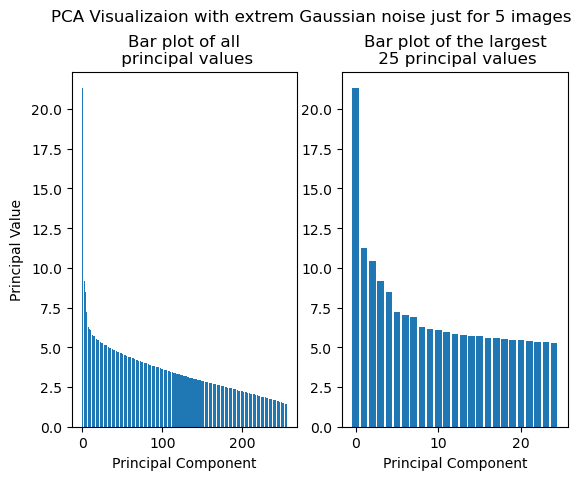

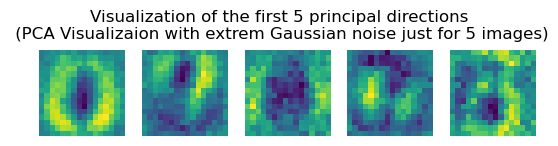

In [15]:
visualisation5_images(images_extrem_noise, "PCA Visualizaion with extrem Gaussian noise just for 5 images")

 Denoise the images by reconstruction from projections on the m largest principal components:
the reconstruction bx of a data point x by the m largest eigenvectors

In [19]:
# denoise
pca = PCA(images)
images_denoise_low=pca.denoise(images_low_noise, m=16)
images_denoise_high=pca.denoise(images_high_noise, m=24)
images_denoise_extrem=pca.denoise(images_extrem_noise, m=4)

[1830, 36, 803, 1903, 1332, 1088, 1606, 1538, 304, 1413]


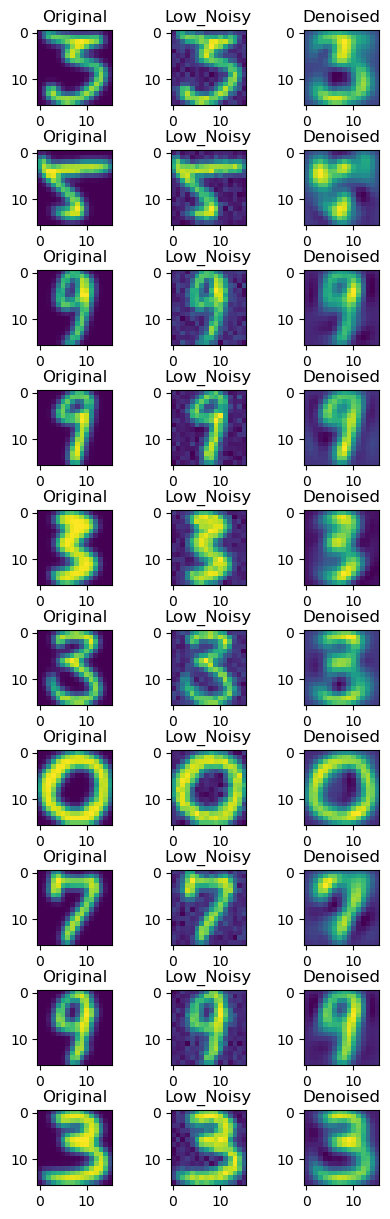

In [20]:
import random
np.random.seed(10)
selected_images = np.random.choice(range(2007), size=10, replace=False).tolist()
print(selected_images)
# Visualization
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(5,15))
for i, image_id in enumerate(selected_images):
    # Plot original image
    axes[i, 0].imshow(images[image_id,:].reshape(16,16))
    axes[i, 0].set_title('Original')

    # Plot noisy image
    axes[i, 1].imshow(images_low_noise[image_id,:].reshape(16,16))
    axes[i, 1].set_title('Low_Noisy')

    # Plot denoised image
    axes[i, 2].imshow(images_denoise_low[image_id,:].reshape(16,16))
    axes[i, 2].set_title('Denoised')


# Adjust layout
fig.subplots_adjust(wspace=0.1, hspace=0.6)
#plt.tight_layout()
#plt.show()


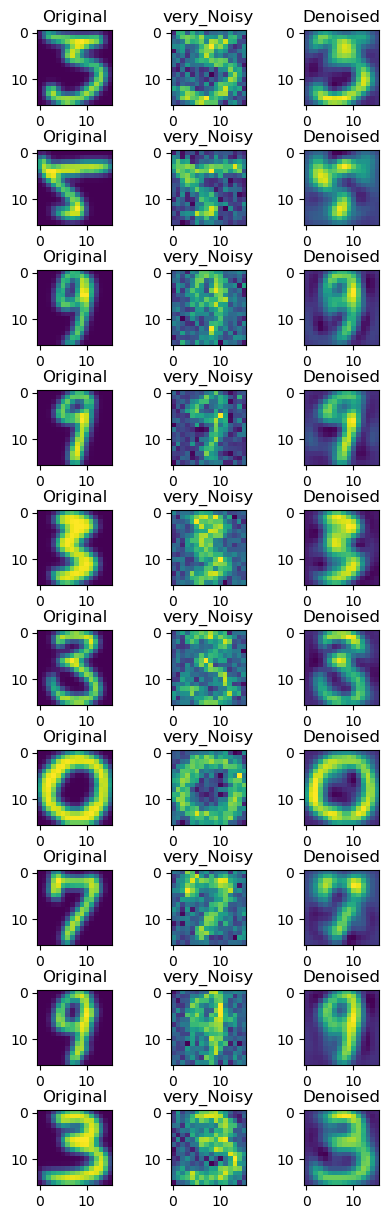

In [21]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(5,15))
for i, image_id in enumerate(selected_images):
    # Plot original image
    axes[i, 0].imshow(images[image_id,:].reshape(16,16))
    axes[i, 0].set_title('Original')

    # Plot noisy image
    axes[i, 1].imshow(images_high_noise[image_id,:].reshape(16,16))
    axes[i, 1].set_title('very_Noisy')

    # Plot denoised image
    axes[i, 2].imshow(images_denoise_high[image_id,:].reshape(16,16))
    axes[i, 2].set_title('Denoised')
    
# Adjust layout
fig.subplots_adjust(wspace=0.1, hspace=0.6)
#plt.tight_layout()
#plt.show()

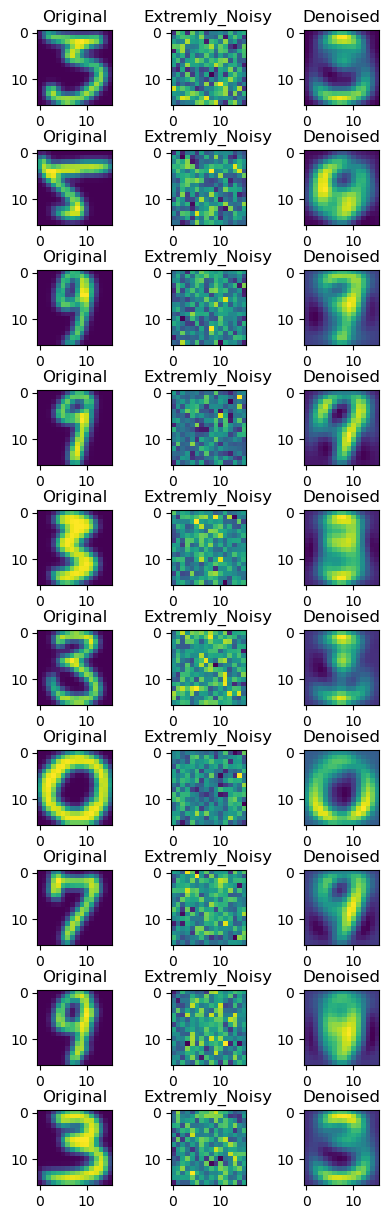

In [22]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(5,15))
for i, image_id in enumerate(selected_images):
    # Plot original image
    axes[i, 0].imshow(images[image_id,:].reshape(16,16))
    axes[i, 0].set_title('Original')

    # Plot noisy image
    axes[i, 1].imshow(images_extrem_noise[image_id,:].reshape(16,16))
    axes[i, 1].set_title('Extremly_Noisy')

    # Plot denoised image
    axes[i, 2].imshow(images_denoise_extrem[image_id,:].reshape(16,16))
    axes[i, 2].set_title('Denoised')

# Adjust layout
fig.subplots_adjust(wspace=0.1, hspace=0.6)

In [23]:
fish_path =  r"data\fishbowl_dense.npz"  

# Load the data from the .npz file
data = np.load(fish_path)
print("Data keys available in the fishbowl_dense file:", data.files)

flat_path =  r"data\flatroll_data.npz"  

# Load the data from the .npz file
data = np.load(flat_path)
print("Data keys available in the flatroll_data file:", data.files)
swiss_path =  r"data\swissroll_data.npz"  

# Load the data from the .npz file
data = np.load(swiss_path)
print("Data keys available in the swissroll_data file:", data.files)
# Specify the path to your .npz file


Data keys available in the fishbowl_dense file: ['X']
Data keys available in the flatroll_data file: ['Xflat', 'true_embedding']
Data keys available in the swissroll_data file: ['el', 'noise', 'e', 'name', 'distances', 'z', 'dataset', 'state', 'n', 'x', 'az', 'typ', 'col', 'x_noisefree', 'D']


In [25]:
def load_npz_data(file_path):
    
    data = np.load(file_path)
    print(data)
    
    X = data['data'].T  # Transpose to align to standard shape of (n_samples, n_features)
    y = data['label'].flatten()  # Flatten to make it a 1D array
    
    # Filter to keep only the positive class (label 1)
    positive_class = X[y == 1]
    
    return positive_class

file_path =  r"data\banana.npz"  
positive_class_data = load_npz_data(file_path)
print("Loaded positive class data shape:", positive_class_data.shape)

NpzFile 'data\\banana.npz' with keys: data, label
Loaded positive class data shape: (2376, 2)


Loaded positive class data shape: (2376, 2)


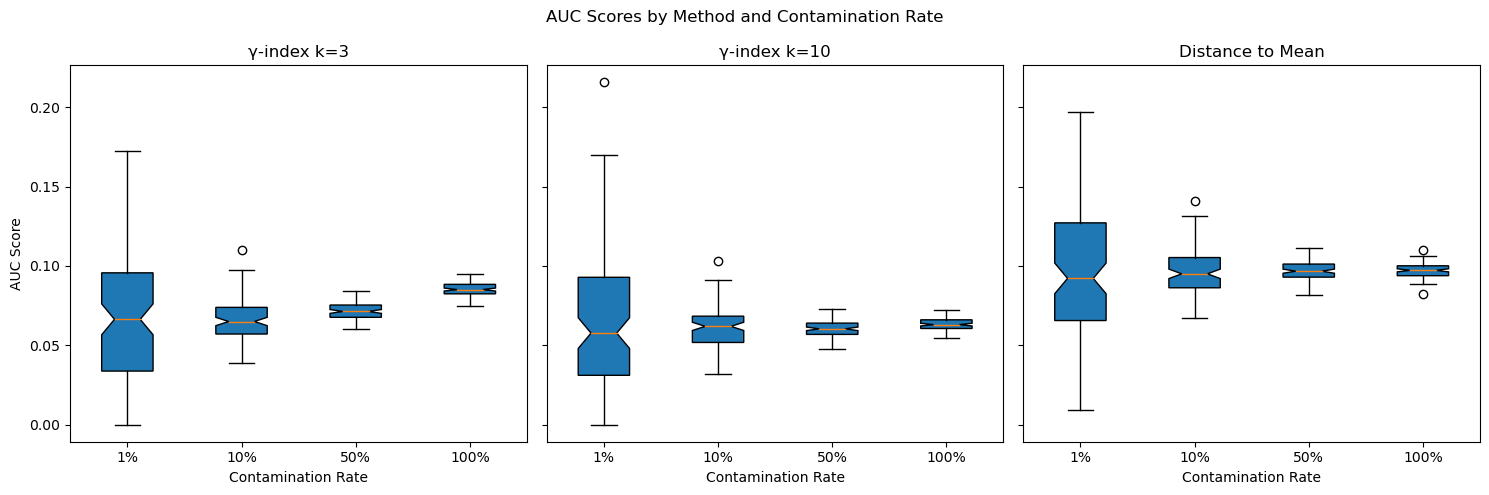

In [26]:
def simulate_outliers(data, rate, bounding_box=(-4, 4)):
    num_outliers = int(len(data) * rate)
    outliers = np.random.uniform(low=bounding_box[0], high=bounding_box[1], size=(num_outliers, data.shape[1]))
    return np.vstack([data, outliers]), np.array([1] * len(data) + [-1] * num_outliers)

def compute_g_index(X, k):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X)
    distances, _ = nbrs.kneighbors(X)
    return distances[:, -1]

def distance_to_mean(X):
    mean_point = np.mean(X, axis=0)
    return np.linalg.norm(X - mean_point, axis=1)
def calculate_auc_scores(data, contamination_rates, n_runs=100):
    auc_scores = {rate: ([], [], []) for rate in contamination_rates}

    for rate in contamination_rates:
        for _ in range(n_runs):
            noisy_data, labels = simulate_outliers(data, rate)

            g3 = compute_g_index(noisy_data, k=3)
            g10 = compute_g_index(noisy_data, k=10)
            dist_mean = distance_to_mean(noisy_data)

            auc_scores[rate][0].append(auc(labels, g3))
            auc_scores[rate][1].append(auc(labels, g10))
            auc_scores[rate][2].append(auc(labels, dist_mean))

    return auc_scores

def visualize_auc(auc_scores):
    methods = ['γ-index k=3', 'γ-index k=10', 'Distance to Mean']
    contamination_rates = sorted(auc_scores.keys())

    num_methods = len(methods)

    fig, axes = plt.subplots(1, num_methods, figsize=(15, 5), sharey=True)
    fig.suptitle('AUC Scores by Method and Contamination Rate')

    for i, method in enumerate(methods):
        data = [auc_scores[rate][i] for rate in contamination_rates]

        axes[i].boxplot(data, notch=True, patch_artist=True)
        axes[i].set_title(method)
        axes[i].set_xticks(range(1, len(contamination_rates) + 1))
        axes[i].set_xticklabels([f"{int(rate * 100)}%" for rate in contamination_rates])
        axes[i].set_xlabel('Contamination Rate')
        if i == 0:
            axes[i].set_ylabel('AUC Score')

        for patch in axes[i].artists:
            patch.set_facecolor(np.random.rand(3,)) 

    plt.tight_layout()
    plt.show()

print("Loaded positive class data shape:", positive_class_data.shape)
contamination_rates = [0.01, 0.1, 0.5, 1.0]
auc_scores = calculate_auc_scores(positive_class_data, contamination_rates)
visualize_auc(auc_scores)

[[ 0.467791    0.98437782 -0.58102671 ... -0.61722143 -0.60623704
   0.72775064]
 [ 0.40030109  0.03773982 -0.66112423 ... -0.51813295  0.60862648
  -0.59576953]
 [-0.78799151 -0.17197677  0.4746817  ... -0.59209455  0.51190864
  -0.33976121]]


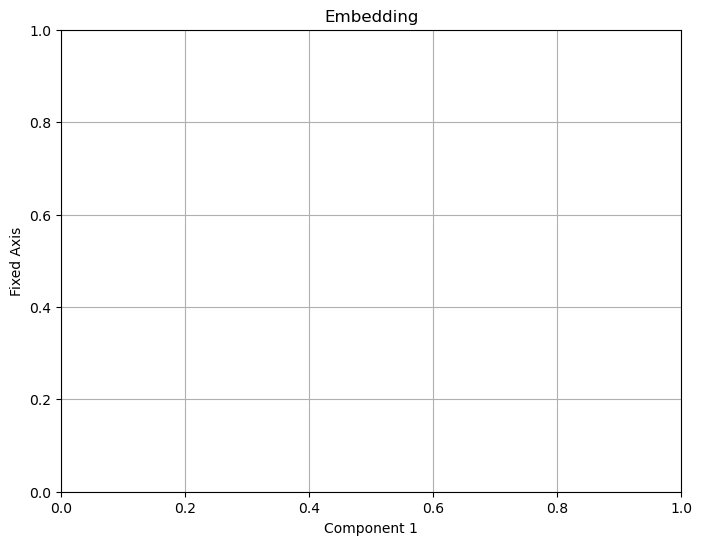

In [27]:
def load_fishbowl_data(file_path):
    with np.load(file_path) as data:
        X = data['X']
    return X
fishbowl_data = load_fishbowl_data(fish_path)
print(fishbowl_data)
def plot_fish_embedding(X, title="Embedding"):
    plt.figure(figsize=(8, 6))
    if X.shape[1] == 2:
        plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    elif X.shape[1] == 1:
        plt.scatter(X[:, 0], [0] * len(X), alpha=0.6)  # Plotting 1D data
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2" if X.shape[1] == 2 else "Fixed Axis")
    plt.grid(True)
    plt.show()
plot_fish_embedding(fishbowl_data)

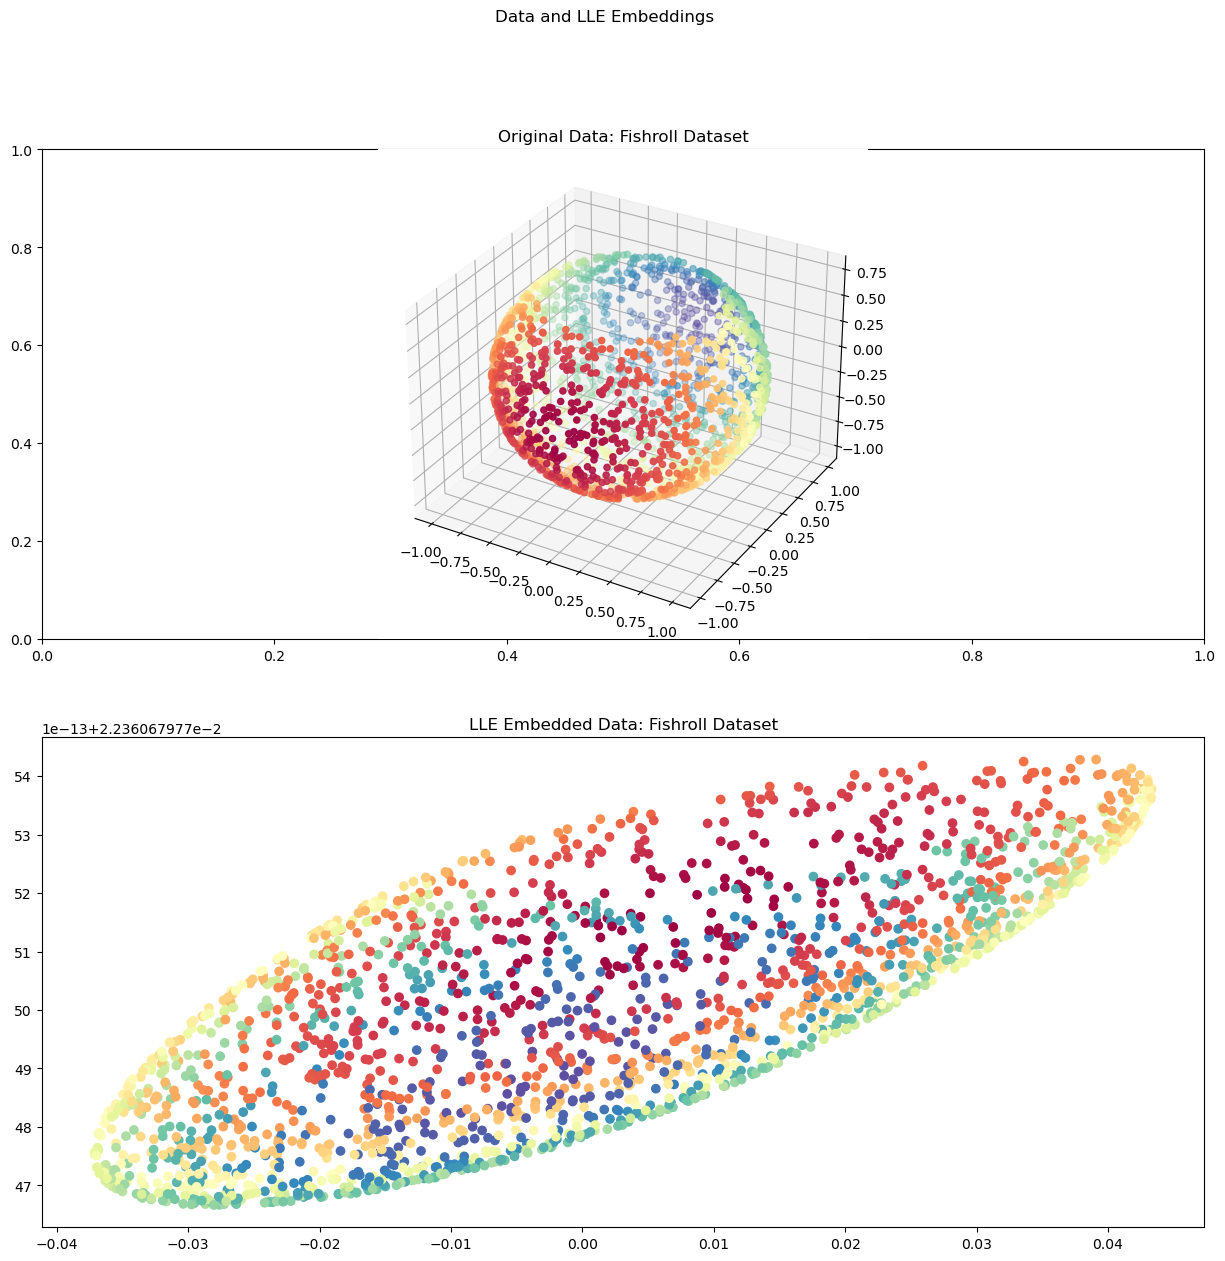

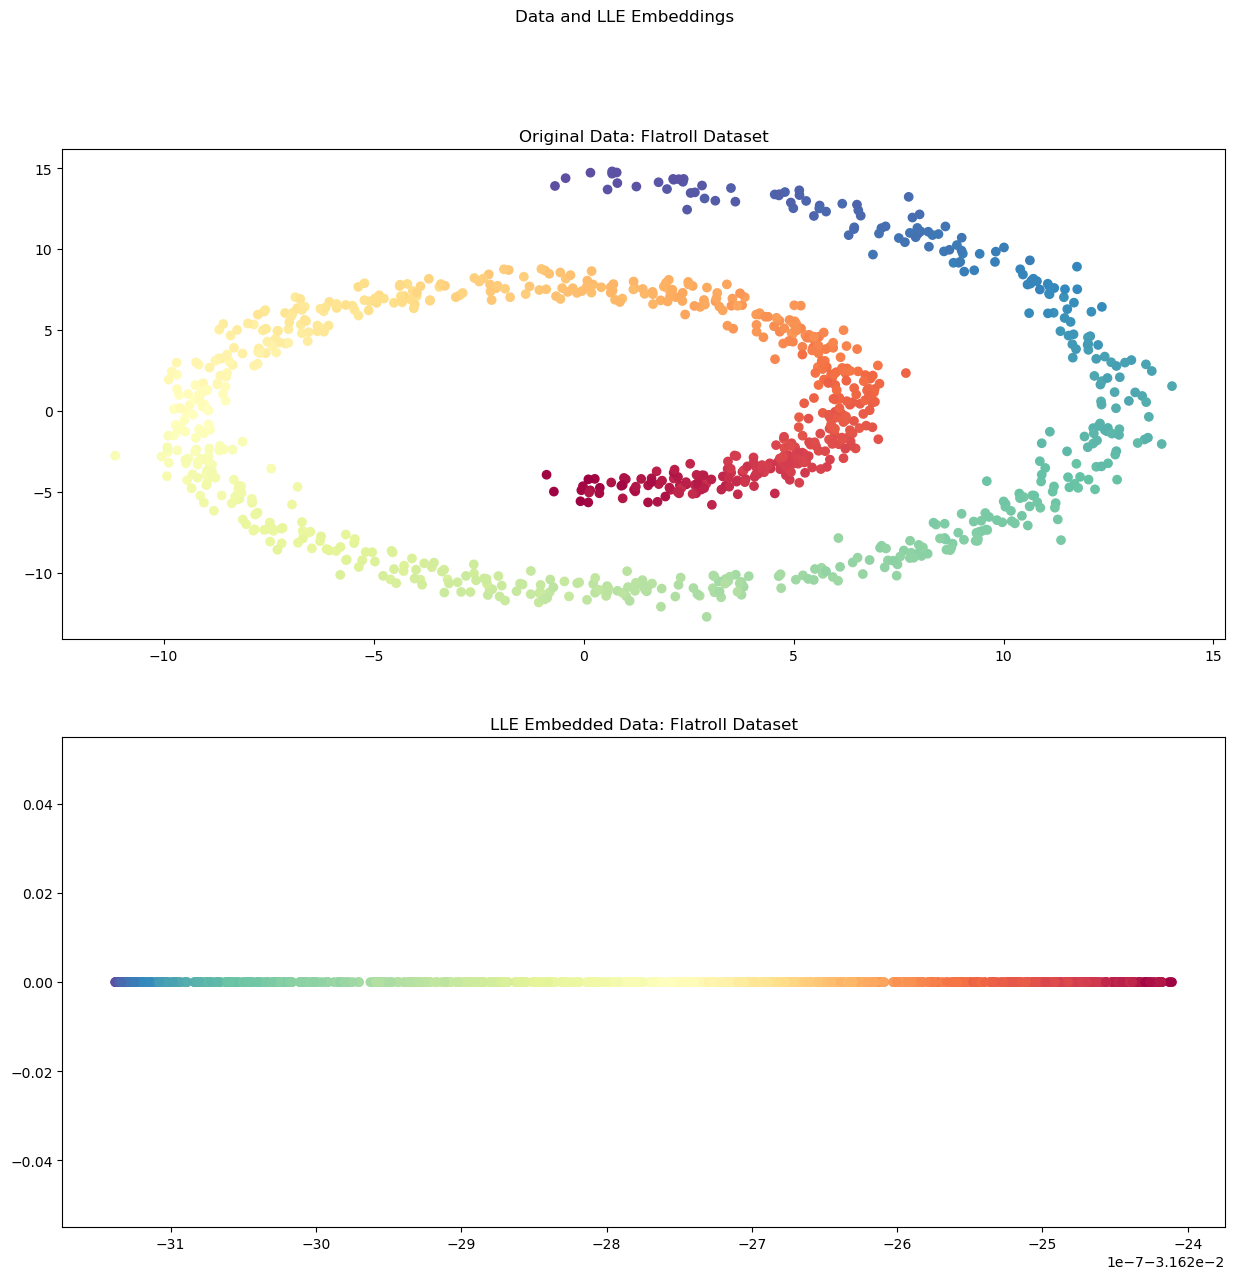

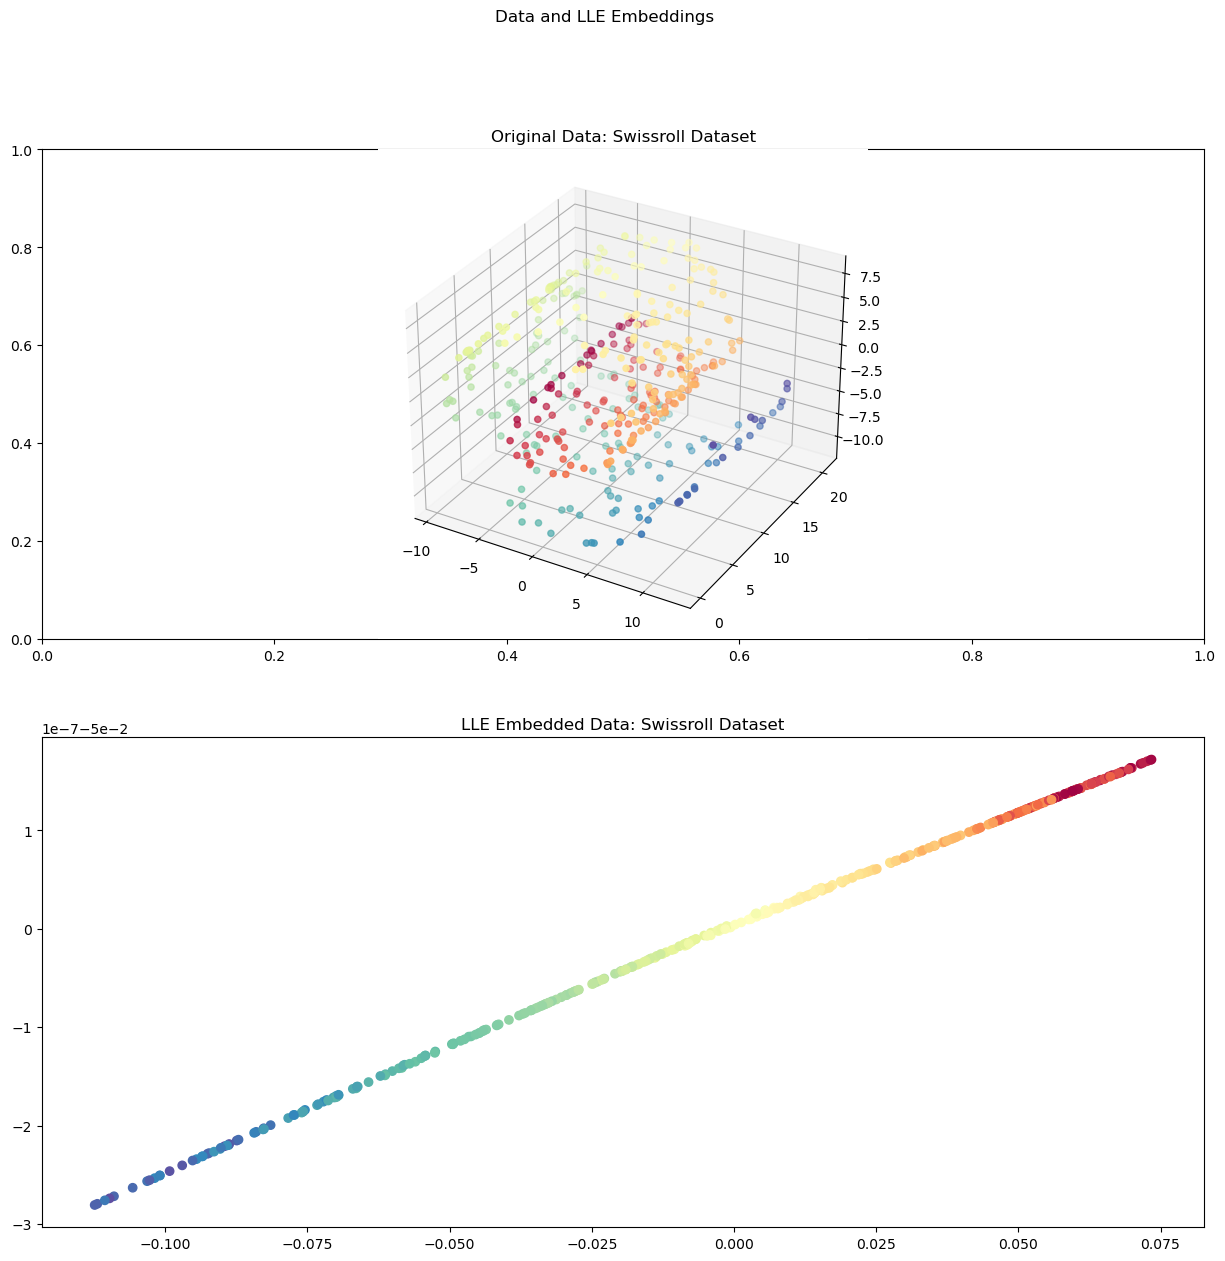

In [29]:
from scipy.spatial import distance
def lle(X, m, tol, n_rule='knn', k=None, epsilon=None):
    N = len(X)
    W = np.zeros((N, N))

    # Ensure k does not exceed number of available points
    if k is not None and k >= N:
        k = N - 1  # Set k to max possible which is N-1

    dists = distance.cdist(X, X, 'euclidean')
    
    for i in range(N):
        if n_rule == 'knn':
            if k is not None:
                ind = np.argpartition(dists[i], min(k+1, N-1))[1:k+1]
            else:
                raise ValueError("k must be set for 'knn'")
            Eta = X[ind]
        elif n_rule == 'eps-ball':
            if epsilon is not None:
                ind = np.where(dists[i] < epsilon)[0]
            else:
                raise ValueError("epsilon must be provided for 'eps-ball'")
            Eta = X[ind]
        else:
            raise Exception('Invalid n_rule.')

        A = X[i] - Eta
        C = A @ A.T + np.eye(len(ind)) * tol
        w = np.linalg.solve(C, np.ones(len(ind)))
        w /= np.sum(w)
        W[i, ind] = w
    
    M = np.identity(N) - W - W.T + W.T @ W
    E = np.linalg.svd(M)[0][:, -m:]
    
    return E


def plot_embedding(X, X_embedded, title="LLE Embedding", colors=None):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    plt.suptitle(title)
    
    ax1 = fig.add_subplot(121, projection='3d' if X.shape[1] == 3 else None)
    scatter_args = {'c': colors, 'cmap': plt.cm.Spectral} if colors is not None else {}
    if X.shape[1] == 3:
        ax1.scatter(X[:, 0], X[:, 1], X[:, 2], **scatter_args)
    elif X.shape[1] == 2:
        ax1.scatter(X[:, 0], X[:, 1], **scatter_args)
    ax1.set_title("Original Data")

    ax2 = fig.add_subplot(122)
    if X_embedded.shape[1] == 1:
        ax2.scatter(X_embedded[:, 0], np.zeros_like(X_embedded[:, 0]), **scatter_args)
    else:
        ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], **scatter_args)
    ax2.set_title("Embedded Data")

    plt.show()
    
def plot_fish_embedding(X, title="Embedding"):
    plt.figure(figsize=(8, 6))
    if X.shape[1] == 2:
        plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    elif X.shape[1] == 1:
        plt.scatter(X[:, 0], [0] * len(X), alpha=0.6) 
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2" if X.shape[1] == 2 else "Fixed Axis")
    plt.grid(True)
    plt.show()


fish_path =  r"data\fishbowl_dense.npz" 
flat_path =  r"data\flatroll_data.npz" 
swiss_path =  r"data\swissroll_data.npz" 

def load_fishbowl_data(file_path):
    with np.load(file_path) as data:
        X = data['X']
    return X

def load_flatroll_data(file_path):
    with np.load(file_path) as data:
        Xflat = data['Xflat']
        true_embedding = data['true_embedding']
    return Xflat, true_embedding

def load_swissroll_data(file_path):
    with np.load(file_path) as data:
        X = data['x_noisefree']  
        colors = data['col']  
    return X, colors


def plot_embeddings(datasets, embeddings, titles, colors):
    num_datasets = len(datasets)
    fig, axs = plt.subplots(2, num_datasets, figsize=(15 * num_datasets, 14), squeeze=False)
    plt.suptitle("Data and LLE Embeddings")
   
    for i in range(num_datasets):
        X = datasets[i]
        X_embedded = embeddings[i]
        if colors == None:
            color = None
        elif i < len(colors):
            color = colors[i]  
        
        # data plot
        ax1 = axs[0, i]
        if X.shape[1] == 3:
            ax1 = fig.add_subplot(2, num_datasets, i + 1, projection='3d')
            ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
        elif X.shape[1] == 2:
            ax1.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
        else:
            print(f"Unexpected number of dimensions {X.shape[1]} in dataset {titles[i]}")
        ax1.set_title(f"Original Data: {titles[i]}")
        
        # embedded plot
        ax2 = axs[1, i]
        if X_embedded.shape[1] == 1:
            ax2.scatter(X_embedded[:, 0], np.zeros_like(X_embedded[:, 0]), c=color, cmap=plt.cm.Spectral)
        else:
            ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color, cmap=plt.cm.Spectral)
        ax2.set_title(f"LLE Embedded Data: {titles[i]}")

    plt.show()

    
fishbowl_data = load_fishbowl_data(fish_path)
flatroll_data, flatroll_true_embedding = load_flatroll_data(flat_path)
swissroll_data, swissroll_colors = load_swissroll_data(swiss_path)

# transpose if necessary
fishbowl_data = fishbowl_data.T if fishbowl_data.shape[0] < fishbowl_data.shape[1] else fishbowl_data
flatroll_data = flatroll_data.T if flatroll_data.shape[0] < flatroll_data.shape[1] else flatroll_data
swissroll_data = swissroll_data.T if swissroll_data.shape[0] < swissroll_data.shape[1] else swissroll_data

fishbowl_embedded = lle(fishbowl_data, m=2, tol=0.01, n_rule='knn', k=100)  

flatroll_embedded = lle(flatroll_data, m=1, tol=0.01, n_rule='knn', k=15)  
swissroll_embedded = lle(swissroll_data, m=2, tol=0.01, n_rule='knn', k=6)
fishbowl_colors = fishbowl_data[:, 1]
plot_embeddings([fishbowl_data], [fishbowl_embedded], ["Fishroll Dataset"], [fishbowl_colors])  
plot_embeddings([flatroll_data], [flatroll_embedded], ["Flatroll Dataset"], [flatroll_true_embedding])  

# Handling the swissroll_colors
if isinstance(swissroll_colors, np.ndarray) and swissroll_colors.ndim > 1:
    swissroll_colors = swissroll_colors.flatten()
    
plot_embeddings([swissroll_data], [swissroll_embedded], ["Swissroll Dataset"], [swissroll_colors])

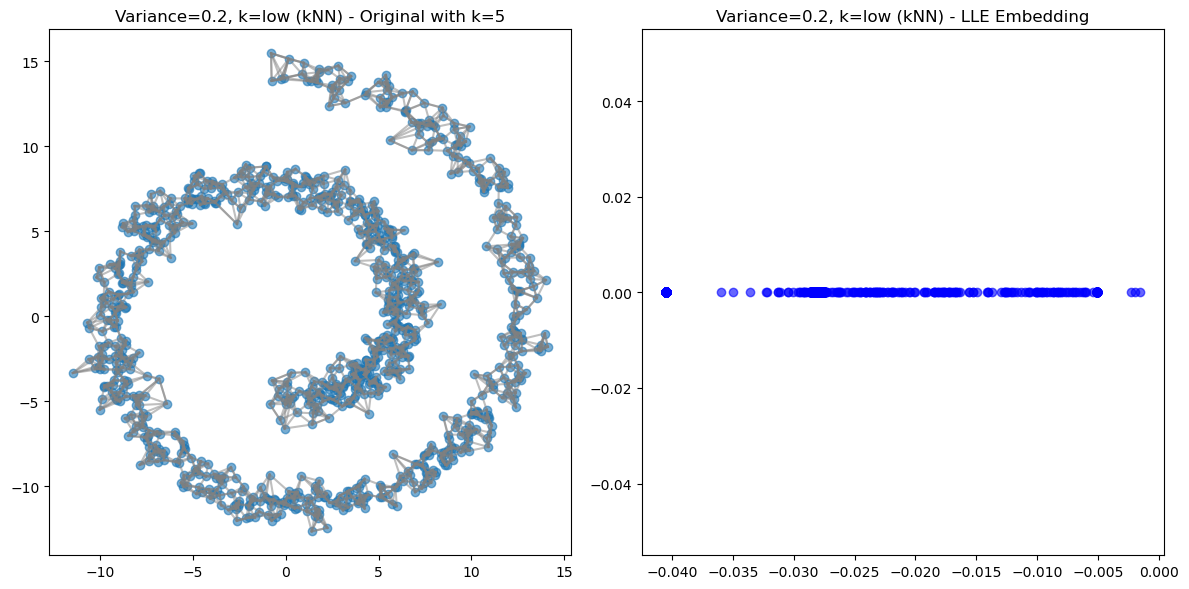

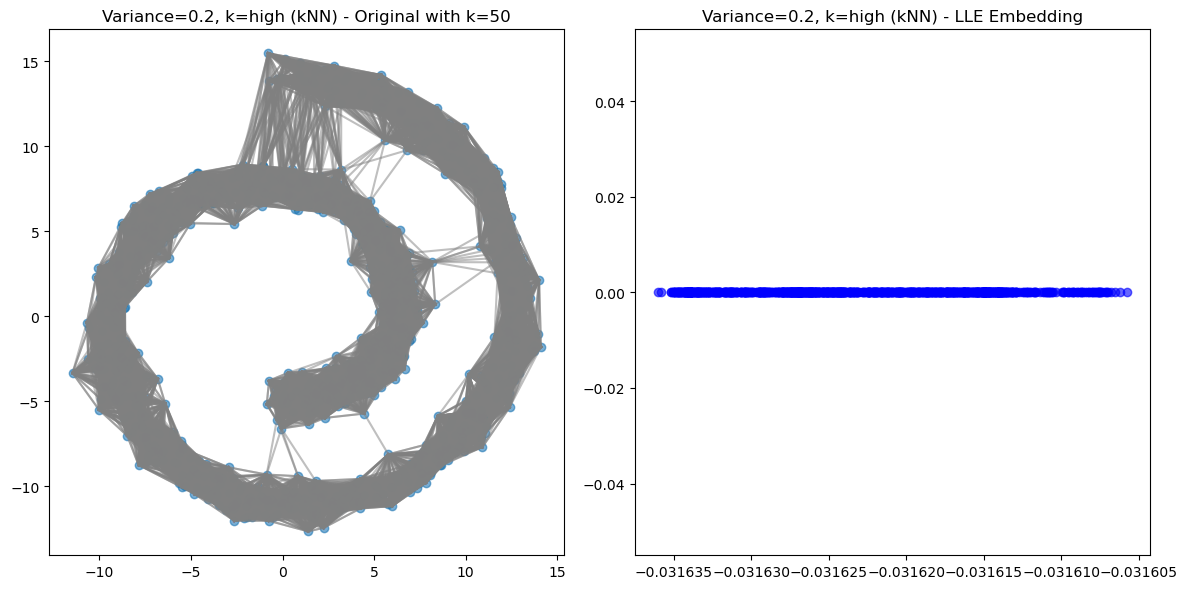

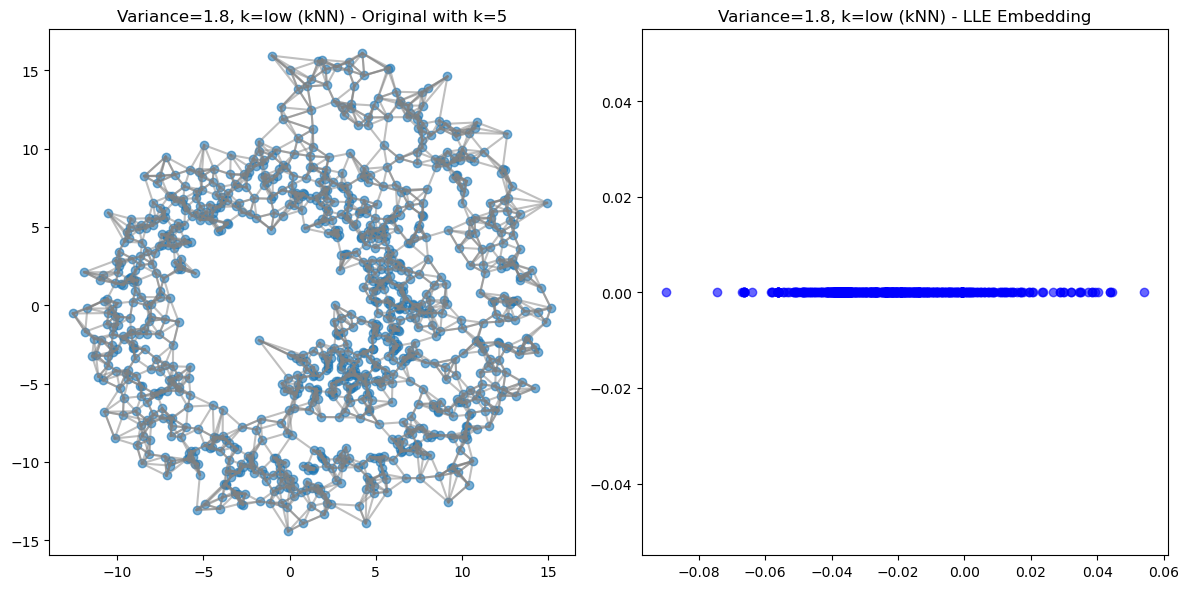

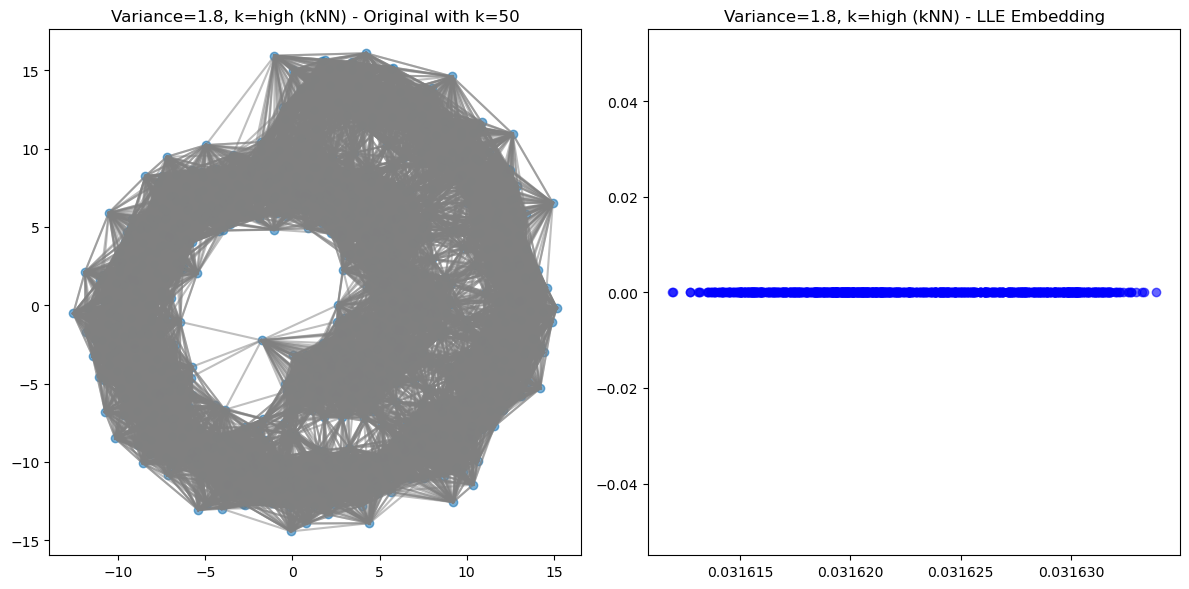

In [30]:
from numpy.random import normal

def add_noise(X, variance):
    noise = normal(loc=0, scale=np.sqrt(variance), size=X.shape)
    return X + noise


def plot_embedding_with_connections(X, Y, k, title=""):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    dists = distance.cdist(X, X)
    for i in range(len(X)):
        for j in np.argsort(dists[i])[1:k+1]:
            plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], 'gray', alpha=0.5)
    plt.title(f"{title} - Original with k={k}")
    plt.subplot(122)
    plt.scatter(Y[:, 0], np.zeros_like(Y[:, 0]), c='b', alpha=0.6)
    plt.title(f"{title} - LLE Embedding")
    plt.tight_layout()
    plt.show()

flatroll_data, flatroll_true_embedding = load_flatroll_data(flat_path)
flatroll_data = flatroll_data.T  

variances = [0.2, 1.8]
noisy_datasets = {var: add_noise(flatroll_data, var) for var in variances}


k_values = {
    'low': 5,  # Good k value
    'high': 50  # Too large k value
}

for var, data in noisy_datasets.items():
    for k_desc, k in k_values.items():
        embedded_data = lle(data, m=1, tol=0.001, n_rule='knn', k=k)
        plot_embedding_with_connections(data, embedded_data, k, title=f"Variance={var}, k={k_desc} (kNN)")
